# 3. D8-D9 across sessions [FWD-BWD]

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../..')
from data_import import*
from helper import*
from plot_params import*
import seaborn as sns
import scipy as sp
from curlyBrace import curlyBrace
pp = PlotParams()

In [4]:
f4_path = '/Users/szekelyanna/f4/cogtom/cogtom_code_bt/Python/Output/NOGTHSH/'    
file = 'NOGTHSH_ACROSS_SESSIONS_d8_d9_across_session_NOG_d9_216_225.csv'
figsave_loc = '/Users/szekelyanna/Dropbox/CSNL/cognitive_tomography/analysis_2022/plots/across_sessions_d8_d9/'
data = import_and_transform_data(f4_path, file)
data_tag, data = data
print(data_tag)

/Users/szekelyanna/Dropbox/CSNL/cognitive_tomography/analysis_2022/ipynbs/Across sessions/Clean ipnbs [across sessions]/../../data_import.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data = data.drop('Unnamed: 0', 1)


Nr of datapoints: 1,325,314 
chains:['saw' 'camino' 'scissors' 'silkroad'] 
train:['186_195' '216_225'], test:['176_177' '178_179' '180_181' '182_183' '184_185' '201_202' '203_204'
 '205_206' '207_208' '209_210' '211_212' '213_214'] 
data used: NOGTHSH_ACROSS_SESSIONS_d8_d9_across_session_NOG_d9_216_225.csv


In [5]:
def drop_RTs_above_3std(data):
    rt_means = dict(data.groupby('participant')['rt'].mean())
    participants = rt_means.keys()
    rt_means = np.array(data.groupby('participant')['rt'].mean())
    rt_std = np.array(data.groupby('participant')['rt'].std())
    rt_mean_3std = rt_means + 3*rt_std
    rt_mean_3std = dict(zip(participants, rt_mean_3std))
    data['rt_means_3std'] = data['participant'].map(rt_mean_3std)
    data = data.loc[data['rt'] < data['rt_means_3std']]
    return (data)

In [6]:
def corr_computation(data):
    corr_matrix = (data
                           .groupby(['model', 'participant', 'e_train', 'e_test', 'day'])
                           [['rt','rt_predicted']]
                           .corr())

    corr_matrix.reset_index(inplace = True)
    corr_matrix.drop(['level_5', 'rt'], axis = 1, inplace = True)
    matrix = corr_matrix.loc[corr_matrix['rt_predicted'] !=1]
    matrix['r_sqr'] = matrix.rt_predicted**2
    matrix.drop('rt_predicted', 1, inplace = True)
    #data =  matrix.drop('day', axis = 1)
    #data = data.groupby(['model', 'participant', 'e_train', 'e_test']).sum()
    return (matrix)

In [7]:
data_without_cutoff = corr_computation(data)
data_with_cutoff = corr_computation(drop_RTs_above_3std(data))

/var/folders/j5/sdcqcn450vj04kd1_kb4xv6c0000gn/T/ipykernel_63671/2566535092.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix['r_sqr'] = matrix.rt_predicted**2
/var/folders/j5/sdcqcn450vj04kd1_kb4xv6c0000gn/T/ipykernel_63671/2566535092.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  matrix.drop('rt_predicted', 1, inplace = True)
/Users/szekelyanna/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  re

In [8]:
def data_pivot_add_diffs(data):
    data = data.pivot(index = ['day', 'participant', 'e_test'], columns = ['model'], values = ['r_sqr'])
    data = data.unstack(0)
    colnames = [item[1:3] for item in data.columns]
    data.columns = pd.MultiIndex.from_tuples(colnames, names=["model", "day"])
    
    #add_diffs
    data['GT_diff'] = data[('GroundTruth', 9.0)] - data[('GroundTruth', 8.0)]
    data['iHMM_diff'] = data[('iHMM', 8.0)] - data[('iHMM', 9.0)]
    
    
    return (data)

In [9]:
data_with_cutoff = data_pivot_add_diffs(data_with_cutoff)
data_without_cutoff = data_pivot_add_diffs(data_without_cutoff)

In [10]:

# fontdict for curly bracket 1 text
font = {'family': 'serif',
        'color':  'royalblue',
#        'weight': 'bold',
       'style': 'normal',
        'size': pp.ticklabsize,
        }

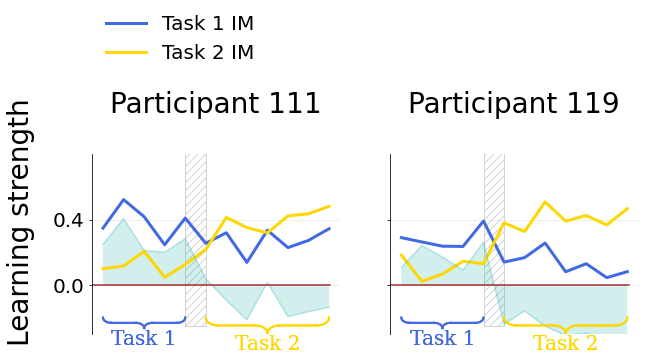

In [11]:
y =-0.2
k_r1 = 0.1


n_row, n_col = 1,2

participants = [111, 119]
fig, axs = plt.subplots(n_row, n_col, sharex=True, sharey=True, figsize = (9.8, 5.2))
#fig.tight_layout(pad=10)
r, c = 0,0
for p in participants:
    
    ########################################
    ### Lineplots and fillings 
    ########################################
    axs[c].plot(data_with_cutoff.loc[p, ('iHMM', 8)], label = "Task 1 IM", color = 'royalblue', lw = 3)
    axs[c].plot(data_with_cutoff.loc[p, ('iHMM', 9)], label = "Task 2 IM", color = 'gold', lw = 3)
    axs[c].plot(data_with_cutoff.loc[p, 'iHMM_diff'], color = "lightseagreen", alpha = 0.3)
    
    
    
    axs[c].fill_between(x = data_with_cutoff.loc[p, 'iHMM_diff'].index,
                           y1 = 0, 
                           y2 = data_with_cutoff.loc[p, 'iHMM_diff'],
                           facecolor = 'lightseagreen', 
                           alpha = 0.2) #,
                           #label = "D9 CT advantage over D8 CT")

    
    
    ########################################
    ### Vertical and horisontal lines 
    ########################################
    axs[c].axhline(y = 0, xmax = 0.96, color = 'brown', linestyle = '-')
    axs[c].fill_betweenx(y =np.array([-0.25,0.9]),
                           x1 = 4, 
                           x2 = 5,
                           edgecolor = 'lightgray', #'#E0C568FF',
                           hatch='///',
                           zorder = 0.8,
                           facecolor = 'white')
                           #label = "Boundary between D8 and D9 test blocks")
    axs[c].set_title('Participant ' + str(p), fontsize = pp.titlefontsize, y = 1.2)
    #axs[0].set_ylabel('Learning strength', fontsize = pp.axlabsize)

    c += 1
    if c == n_col:
        c = 0
        r+= 1
    
    for ax in fig.axes:

        plt.sca(ax)
        plt.xticks([])
        plt.yticks([0,0.4], fontsize = pp.ticklabsize)
        plt.ylim(-0.3, 0.8)
        plt.grid(c = 'lightgray', alpha = 0.5)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        
        ax.spines['bottom'].set_color('#1C2833') 
        ax.spines['right'].set_color('#1C2833')
        
        
        ########################
        ####### CurlyBrace
        ########################


        p1, p2 = [4, y], [0.0, y]
        font['color'] = 'royalblue'
        curlyBrace(fig, ax, p1, p2, k_r1, bool_auto=True, str_text='Task 1', 
                   color = font['color'], lw=2, int_line_num=1, fontdict=font)


        p1, p2 = [11, y], [5, y]
        font['color'] = 'gold'
        curlyBrace(fig, ax, p1, p2, k_r1, bool_auto=True, str_text='Task 2', 
                   color = font['color'], lw=2, int_line_num=1, fontdict=font)


############################
## Legend
############################
handles, labels = axs[c].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.12,1.3), loc="upper left", ncol=1, fontsize=pp.legendfontsize, frameon = False)


fig.text(0.025, 0.7, 'Learning strength', va='center', rotation='vertical', fontsize=pp.axlabsize,horizontalalignment='center')
#fig.suptitle('C: Under new conditions a new internal model is learned', x = 0.47, y = 1.05, fontsize=18)
#fig.text(0.5, 0.22, 'Test blocks', ha='center', va='center', fontsize=20)

fig.subplots_adjust(bottom=0.4)

In [12]:
# fig.savefig('/Users/szekelyanna/Dropbox/CSNL/cognitive_tomography/analysis_2022/plots/manuscript_plots_standard/' +'crossover.pdf', bbox_inches='tight')
# fig.savefig('/Users/szekelyanna/Dropbox/CSNL/cognitive_tomography/analysis_2022/plots/manuscript_plots_standard/' +'crossover.png', bbox_inches='tight')